In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('Base de datos v1.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Cliente               20000 non-null  int64  
 1   Edad                     19700 non-null  float64
 2   Genero                   20000 non-null  object 
 3   Estado_Civil             20000 non-null  object 
 4   Ingreso_Mensual          19500 non-null  float64
 5   Transacciones_Mensuales  20000 non-null  int64  
 6   Monto_Promedio_Compra    19800 non-null  float64
 7   Uso_Linea_Credito_Pct    20000 non-null  float64
 8   Pagos_Atrasados          20000 non-null  int64  
 9   Antiguedad_Meses         20000 non-null  int64  
 10  Productos_Adicionales    20000 non-null  int64  
 11  Fuga                     20000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1.8+ MB


In [4]:
data.describe()

,ID_Cliente,Edad,Ingreso_Mensual,Transacciones_Mensuales,Monto_Promedio_Compra,Uso_Linea_Credito_Pct,Pagos_Atrasados,Antiguedad_Meses,Productos_Adicionales,Fuga
count,20000.000000,19700.000000,19500.000000,20000.000000,19800.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,10000.500000,40.187360,4006.623795,31.496050,519.013752,0.285052,0.802350,35.80920,1.088500,0.185350
std,5773.647028,11.628559,2848.305669,31.443938,413.345305,0.159271,0.894217,35.80716,1.204259,0.388591
min,1.000000,18.000000,200.000000,12.000000,23.540000,0.000000,0.000000,1.00000,0.000000,0.000000
25%,5000.750000,32.000000,1916.000000,26.000000,252.875000,0.160000,0.000000,10.00000,0.000000,0.000000
50%,10000.500000,40.000000,3351.000000,30.000000,406.355000,0.260000,1.000000,25.00000,1.000000,0.000000
75%,15000.250000,48.000000,5373.000000,34.000000,647.460000,0.390000,1.000000,50.00000,2.000000,0.000000
max,20000.000000,75.000000,28733.000000,967.000000,6635.400000,0.900000,6.000000,240.00000,8.000000,1.000000


In [5]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       1.5
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            2.5
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      1.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Imputación nulos

In [6]:
data.dropna(subset=['Edad', 'Ingreso_Mensual', 'Monto_Promedio_Compra'], inplace=True)

In [7]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       0.0
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            0.0
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      0.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Distribución de variable objetivo

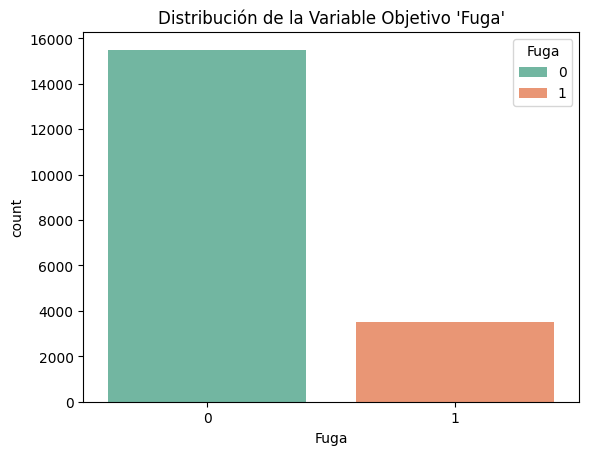

In [8]:
sns.countplot(data=data, x='Fuga', hue='Fuga', palette="Set2")
plt.title("Distribución de la Variable Objetivo 'Fuga'")
plt.show()


Fuga (variable objetivo): El dataset está desbalanceado, lo cual puede requerir técnicas de balanceo para modelos predictivos.


## Pipelines de Cross Validation en la Data cruda usando distintas técnicas de undersampling

In [9]:
RSEED = 42

In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, recall_score, precision_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, confusion_matrix, classification_report
)

# Samplers / Ensembles
from imblearn.under_sampling import (
    RandomUnderSampler, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule
)
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier


### División de data al principio para evitar leakage

In [14]:
# =========================================================
# 0) Datos y división honesta (test imbalanced intacto)
# =========================================================
y = data['Fuga'].astype(int)
X = data.drop(columns=['Fuga'])

num_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RSEED
)


### Preprocesamiento genérico 

In [ ]:
# =========================================================
# 1) Preprocesamiento por tipo de variable
# =========================================================
pre_num = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

# Usa sparse=False para compatibilidad amplia (si tienes sklearn >=1.2 usa sparse_output=False)
pre_cat = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('oh',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre = ColumnTransformer([
    ('num', pre_num, num_cols),
    ('cat', pre_cat, cat_cols)
])

### Definición de pipelines de distintos tipos de undersampling

In [28]:
# =========================================================
# 2) Definir modelos / estrategias a comparar
#    - Baseline con pesos
#    - Undersampling avanzado (NCR, IHT, NearMiss)
#    - Ensembles balanceados (Balanced RF, EasyEnsemble)
# =========================================================
pipelines = {}

# 2.1) Baseline honesto sin remuestrear (pesos balanceados)
pipelines['logit_weighted'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))
])

# 2.2) Random undersampling (ratio 1:2) + Logit
pipelines['logit_random_under_1to2'] = Pipeline(steps=[
    ('pre', pre),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),  # pos:maj = 1:2
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.3) NCR (limpieza de vecindario) -> RandomUnderSampler + Logit
pipelines['logit_ncr_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('clean', NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.4) IHT (conserva casos difíciles) -> RandomUnder + Logit
pipelines['logit_iht_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('iht', InstanceHardnessThreshold(
        estimator=LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
        random_state=RSEED)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=RSEED)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.5) NearMiss v1 (frontera) + Logit (ojo: sensible a escalado; ya escalamos numéricas)
pipelines['logit_nearmiss_v1'] = Pipeline(steps=[
    ('pre', pre),
    ('nm', NearMiss(version=1)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.6) Balanced Random Forest (undersampling interno por árbol)
pipelines['balanced_rf'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', BalancedRandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=RSEED, n_jobs=-1))
])

# 2.7) EasyEnsemble (múltiples subconjuntos balanceados + AdaBoost)
pipelines['easy_ensemble'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', EasyEnsembleClassifier(n_estimators=10, random_state=RSEED, n_jobs=-1))
])

# Opcional: si tienes XGBoost/LightGBM instalados, puedes añadirlos sin remuestreo usando pesos.
# from xgboost import XGBClassifier
# pipelines['xgb_weighted'] = Pipeline(steps=[
#     ('pre', pre),
#     ('clf', XGBClassifier(
#         n_estimators=600, max_depth=4, learning_rate=0.05,
#         subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
#         tree_method='hist', eval_metric='aucpr',
#         scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
#         random_state=RSEED))
# ])

### Cross Validation

In [29]:
# =========================================================
# 3) Cross-Validation 5 × 10 con métricas relevantes
# =========================================================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RSEED)

scoring = {
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',  # PR-AUC
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy',
    'matthews_corrcoef': 'matthews_corrcoef'
}

def evaluar_pipelines(pipelines, X, y, cv, scoring):
    filas = []
    for nombre, pipe in pipelines.items():
        res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
        fila = {'modelo': nombre}
        for m in scoring.keys():
            vals = res['test_' + m]
            fila[m + '_mean'] = vals.mean()
            fila[m + '_std']  = vals.std(ddof=1)
        filas.append(fila)
    resumen = pd.DataFrame(filas).sort_values('average_precision_mean', ascending=False)
    return resumen

cv_summary = evaluar_pipelines(pipelines, X_train, y_train, cv, scoring)

print(cv_summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

                     modelo  roc_auc_mean  roc_auc_std  average_precision_mean  average_precision_std  recall_mean  recall_std  precision_mean  precision_std  f1_mean  f1_std  balanced_accuracy_mean  balanced_accuracy_std  matthews_corrcoef_mean  matthews_corrcoef_std
              easy_ensemble        0.5811       0.0133                  0.2397                 0.0118       0.4722      0.0229          0.2445         0.0084   0.3221  0.0111                  0.5706                 0.0098                  0.1144                 0.0158
             logit_weighted        0.5562       0.0143                  0.2196                 0.0101       0.6273      0.0273          0.2069         0.0058   0.3111  0.0096                  0.5409                 0.0112                  0.0641                 0.0176
                balanced_rf        0.5562       0.0118                  0.2190                 0.0075       0.2184      0.0160          0.2436         0.0154   0.2302  0.0148                  0

### Mejor PR-AUC y evaluación en test real

In [49]:
# =========================================================
# 4) Elegir el mejor por PR-AUC y evaluar en test real
#    Incluye ajuste de umbral por F1 en PR curve
# =========================================================
best_name = cv_summary.iloc[0]['modelo']
best_pipe = pipelines[best_name]
print(f"\nMejor según CV (PR-AUC): {best_name}")

# Reentrenar en TODO el train
best_pipe.fit(X_train, y_train)

# Predicciones en test
if hasattr(best_pipe, "predict_proba"):
    prob_test = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe, "decision_function"):
    # estandarizar a [0,1] vía min-max para PR curve si no hay proba
    df_raw = best_pipe.decision_function(X_test)
    df_min, df_max = df_raw.min(), df_raw.max()
    prob_test = (df_raw - df_min) / (df_max - df_min + 1e-12)
else:
    # fallback a predicción dura (no ideal para PR-AUC)
    prob_test = best_pipe.predict(X_test)

# Métricas continuas
roc = roc_auc_score(y_test, prob_test)
apr = average_precision_score(y_test, prob_test)
print(f"\n[Test] ROC-AUC: {roc:.4f} | PR-AUC: {apr:.4f}")

# Umbral por defecto 0.5
pred_05 = (prob_test >= 0.5).astype(int)
def report(y_true, y_pred, tag):
    print(f"\n[Test] {tag}")
    print(" Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))
    print(f" Recall: {recall_score(y_true, y_pred):.4f} | Precision: {precision_score(y_true, y_pred):.4f} | "
          f"F1: {f1_score(y_true, y_pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, y_pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")

report(y_test, pred_05, "Umbral 0.5")

# Ajuste de umbral maximizando F1 en PR curve
prec, rec, thr = precision_recall_curve(y_test, prob_test)
f1_vals = 2 * prec * rec / (prec + rec + 1e-12)
# Nota: precision_recall_curve devuelve len(thr) = len(prec) - 1
best_idx = np.nanargmax(f1_vals[:-1])  # excluir el último punto (sin umbral)
best_thr = thr[best_idx]
pred_star = (prob_test >= best_thr).astype(int)

report(y_test, pred_star, f"Umbral óptimo por F1 (t* = {best_thr:.4f})")




Mejor según CV (PR-AUC): easy_ensemble

[Test] ROC-AUC: 0.5815 | PR-AUC: 0.2244

[Test] Umbral 0.5
 Confusion matrix:
 [[2044 1056]
 [ 365  338]]
              precision    recall  f1-score   support

           0     0.8485    0.6594    0.7421      3100
           1     0.2425    0.4808    0.3224       703

    accuracy                         0.6263      3803
   macro avg     0.5455    0.5701    0.5322      3803
weighted avg     0.7365    0.6263    0.6645      3803

 Recall: 0.4808 | Precision: 0.2425 | F1: 0.3224 | BalAcc: 0.5701 | MCC: 0.1129

[Test] Umbral óptimo por F1 (t* = 0.4338)
 Confusion matrix:
 [[1488 1612]
 [ 246  457]]
              precision    recall  f1-score   support

           0     0.8581    0.4800    0.6156      3100
           1     0.2209    0.6501    0.3297       703

    accuracy                         0.5114      3803
   macro avg     0.5395    0.5650    0.4727      3803
weighted avg     0.7403    0.5114    0.5628      3803

 Recall: 0.6501 | Precision: 

### Umbrales por costo de negocio

In [ ]:
# =========================================================
# 5) (Opcional) Umbral por costos de negocio
#    Si costo(FN)=C_FN y costo(FP)=C_FP, umbral ≈ C_FN / (C_FN + C_FP)
# =========================================================
# C_FN, C_FP = 5.0, 1.0
# thr_cost = C_FN / (C_FN + C_FP)
# pred_cost = (prob_test >= thr_cost).astype(int)
# report(y_test, pred_cost, f"Umbral por costos (t*={thr_cost:.3f}, C_FN={C_FN}, C_FP={C_FP})")

## Grid search en la Data Cruda undersampleada

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV  

### Easy ensembler Pipeline y parametros

In [32]:
pipe_easy = Pipeline(steps=[
    ('pre', pre),
    ('clf', EasyEnsembleClassifier(random_state=RSEED, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

# Nota: EasyEnsemble entrena un AdaBoost por subconjunto balanceado.
# Afinamos: nº de subconjuntos, el AdaBoost interno y el depth de su árbol débil.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_grid_easy = {
    'clf__n_estimators': [5, 10, 20],                               # nº de subconjuntos balanceados
    'clf__sampling_strategy': [1.0],                            # 1.0=1:1, (pos:maj)
    'clf__estimator': [AdaBoostClassifier(random_state=RSEED)],      # AdaBoost interno
    'clf__estimator__n_estimators': [50, 100, 200],                  # iteraciones de AdaBoost
    'clf__estimator__learning_rate': [0.05, 0.1, 0.2, 1.0],
    'clf__estimator__estimator': [DecisionTreeClassifier(max_depth=1, random_state=RSEED),
                                  DecisionTreeClassifier(max_depth=2, random_state=RSEED)],
    'clf__estimator__estimator__min_samples_leaf': [1, 5]
}

### Easy ensembler grid search y calibración de umbral

In [33]:
gs_easy = GridSearchCV(
    estimator=pipe_easy,
    param_grid=param_grid_easy,
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'},
    refit='pr_auc',  # elige por PR-AUC
    cv=cv, n_jobs=-1, verbose=1, return_train_score=False
)
gs_easy.fit(X_train, y_train)

print("\n=== EasyEnsemble – mejor configuración (por PR-AUC CV) ===")
print(gs_easy.best_params_)
print(f"Best PR-AUC (CV): {gs_easy.best_score_:.4f}")

best_easy = gs_easy.best_estimator_

# ============================
# 3) Calibración + Umbral (solo con TRAIN)
# ============================
cal_easy = CalibratedClassifierCV(best_easy, method='isotonic', cv=5)
cal_easy.fit(X_train, y_train)

# Probabilidades calibradas en TRAIN (CV interna de calibración) para elegir umbral
proba_tr = cal_easy.predict_proba(X_train)[:,1]
prec, rec, thr = precision_recall_curve(y_train, proba_tr)

# Encontrar umbral para recall target de 0.7
target_recall = 0.7
recall_diff = np.abs(rec[:-1] - target_recall)  # excluir último punto sin umbral
best_idx_recall = np.argmin(recall_diff)
t_star_recall = thr[best_idx_recall]

# También calcular umbral por F1 para comparación
f1_vals = 2*prec*rec / (prec+rec + 1e-12)
best_idx_f1 = np.nanargmax(f1_vals[:-1])  # último punto no tiene umbral
t_star_f1 = thr[best_idx_f1]

print(f"Umbral para recall target {target_recall}: t* = {t_star_recall:.4f} (recall real: {rec[best_idx_recall]:.4f})")
print(f"Umbral óptimo (F1 en TRAIN): t* = {t_star_f1:.4f}")

# Usar el umbral para recall target
t_star = t_star_recall

Fitting 5 folds for each of 144 candidates, totalling 720 fits

=== EasyEnsemble – mejor configuración (por PR-AUC CV) ===
{'clf__estimator': AdaBoostClassifier(random_state=42), 'clf__estimator__estimator': DecisionTreeClassifier(max_depth=2, random_state=42), 'clf__estimator__estimator__min_samples_leaf': 1, 'clf__estimator__learning_rate': 0.2, 'clf__estimator__n_estimators': 200, 'clf__n_estimators': 10, 'clf__sampling_strategy': 1.0}
Best PR-AUC (CV): 0.2410

=== EasyEnsemble – mejor configuración (por PR-AUC CV) ===
{'clf__estimator': AdaBoostClassifier(random_state=42), 'clf__estimator__estimator': DecisionTreeClassifier(max_depth=2, random_state=42), 'clf__estimator__estimator__min_samples_leaf': 1, 'clf__estimator__learning_rate': 0.2, 'clf__estimator__n_estimators': 200, 'clf__n_estimators': 10, 'clf__sampling_strategy': 1.0}
Best PR-AUC (CV): 0.2410
Umbral para recall target 0.7: t* = 0.1524 (recall real: 0.7042)
Umbral óptimo (F1 en TRAIN): t* = 0.1630
Umbral para recall ta

### Evaluación en test

In [35]:
# ============================
# 4) Evaluación en TEST (intacto e imbalanced)
# ============================
proba_te = cal_easy.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba_te)
apr = average_precision_score(y_test, proba_te)
print(f"\n[EASY] Test ROC-AUC: {roc:.4f} | PR-AUC: {apr:.4f}")

def report(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[EASY] {tag}")
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_true, pred, digits=4))
    print(f"Recall+: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report(y_test, proba_te, 0.5, "Umbral 0.5")
report(y_test, proba_te, t_star_recall, f"Umbral para recall {target_recall} (t*={t_star_recall:.4f})")
report(y_test, proba_te, t_star_f1, f"Umbral t* (opt F1 en TRAIN, t*={t_star_f1:.4f})")


[EASY] Test ROC-AUC: 0.5819 | PR-AUC: 0.2230

[EASY] Umbral 0.5
Matriz de confusión:
 [[3097    3]
 [ 703    0]]
              precision    recall  f1-score   support

           0     0.8150    0.9990    0.8977      3100
           1     0.0000    0.0000    0.0000       703

    accuracy                         0.8144      3803
   macro avg     0.4075    0.4995    0.4488      3803
weighted avg     0.6643    0.8144    0.7317      3803

Recall+: 0.0000 | Precision: 0.0000 | F1: 0.0000 | BalAcc: 0.4995 | MCC: -0.0134

[EASY] Umbral para recall 0.7 (t*=0.1524)
Matriz de confusión:
 [[1324 1776]
 [ 215  488]]
              precision    recall  f1-score   support

           0     0.8603    0.4271    0.5708      3100
           1     0.2155    0.6942    0.3290       703

    accuracy                         0.4765      3803
   macro avg     0.5379    0.5606    0.4499      3803
weighted avg     0.7411    0.4765    0.5261      3803

Recall+: 0.6942 | Precision: 0.2155 | F1: 0.3290 | BalAcc: 

TN FP

FN TP

### Regresión logística pipeline y parámetros

In [ ]:
# ============================
# 5) GRID SEARCH – Logística (baseline)
#    (sin remuestrear; class_weight='balanced')
# ============================
pipe_logit = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=5000, solver='liblinear', class_weight='balanced', random_state=RSEED))
])

# Expanded parameter grid for more candidates
param_grid_logit = {
    'clf__penalty': ['l2', 'l1'],
    'clf__C': np.logspace(-4, 3, 15),          # More C values: 0.0001 to 1000, 15 points
    'clf__solver': ['liblinear'],              # Keep consistent
    'clf__max_iter': [1000, 5000, 10000]      # Different max_iter values
}

print(f"Total combinations to test: {len(param_grid_logit['clf__penalty']) * len(param_grid_logit['clf__C']) * len(param_grid_logit['clf__solver']) * len(param_grid_logit['clf__max_iter'])}")

### Regresión logística grid search y calibración de umbral

In [45]:
gs_logit = GridSearchCV(
    estimator=pipe_logit,
    param_grid=param_grid_logit,
    scoring={'pr_auc':'average_precision', 'roc_auc':'roc_auc'},
    refit='pr_auc',
    cv=cv, n_jobs=-1, verbose=1, return_train_score=False
)
gs_logit.fit(X_train, y_train)

print("\n=== Logística – mejor configuración (por PR-AUC CV) ===")
print(gs_logit.best_params_)
print(f"Best PR-AUC (CV): {gs_logit.best_score_:.4f}")

best_logit = gs_logit.best_estimator_

# Calibración y evaluación en TEST para baseline
cal_log = CalibratedClassifierCV(best_logit, method='isotonic', cv=5)
cal_log.fit(X_train, y_train)

proba_tr_log = cal_log.predict_proba(X_train)[:,1]
prec_l, rec_l, thr_l = precision_recall_curve(y_train, proba_tr_log)

# Encontrar umbral para recall target de 0.7 (usar variable diferente para evitar duplicado)
target_recall_logit = 0.7
recall_diff_l = np.abs(rec_l[:-1] - target_recall_logit)  # excluir último punto sin umbral
best_idx_recall_l = np.argmin(recall_diff_l)
t_star_recall_log = thr_l[best_idx_recall_l]

# También calcular umbral por F1 para comparación
f1_vals_l = 2*prec_l*rec_l / (prec_l+rec_l + 1e-12)
best_idx_f1_l = np.nanargmax(f1_vals_l[:-1])
t_star_f1_log = thr_l[best_idx_f1_l]

print(f"Umbral para recall target {target_recall_logit}: t* = {t_star_recall_log:.4f} (recall real: {rec_l[best_idx_recall_l]:.4f})")
print(f"Umbral óptimo (F1 en TRAIN): t* = {t_star_f1_log:.4f}")

# Usar el umbral para recall target
t_star_log = t_star_recall_log

Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== Logística – mejor configuración (por PR-AUC CV) ===
{'clf__C': np.float64(0.005179474679231213), 'clf__l1_ratio': None, 'clf__penalty': 'l1'}
Best PR-AUC (CV): 0.2289
Umbral para recall target 0.7: t* = 0.1592 (recall real: 0.7682)
Umbral óptimo (F1 en TRAIN): t* = 0.1620

=== Logística – mejor configuración (por PR-AUC CV) ===
{'clf__C': np.float64(0.005179474679231213), 'clf__l1_ratio': None, 'clf__penalty': 'l1'}
Best PR-AUC (CV): 0.2289
Umbral para recall target 0.7: t* = 0.1592 (recall real: 0.7682)
Umbral óptimo (F1 en TRAIN): t* = 0.1620


### Evaluación en test

In [48]:
proba_te_log = cal_log.predict_proba(X_test)[:,1]
roc_l = roc_auc_score(y_test, proba_te_log)
apr_l = average_precision_score(y_test, proba_te_log)
print(f"\n[LOGIT] Test ROC-AUC: {roc_l:.4f} | PR-AUC: {apr_l:.4f}")

def report_log(y_true, proba, thr, tag):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n[LOGIT] {tag}")
    print("Matriz de confusión:\n", cm)
    print(classification_report(y_true, pred, digits=2))
    print(f"Recall+: {recall_score(y_true, pred):.4f} | Precision: {precision_score(y_true, pred):.4f} | "
          f"F1: {f1_score(y_true, pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, pred):.4f}")

report_log(y_test, proba_te_log, 0.5, "Umbral 0.5")
report_log(y_test, proba_te_log, t_star_recall_log, f"Umbral para recall {target_recall_logit} (t*={t_star_recall_log:.4f})")
report_log(y_test, proba_te_log, t_star_f1_log, f"Umbral t* (opt F1 en TRAIN, t*={t_star_f1_log:.4f})")


[LOGIT] Test ROC-AUC: 0.5859 | PR-AUC: 0.2377

[LOGIT] Umbral 0.5
Matriz de confusión:
 [[3100    0]
 [ 703    0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      3100
           1       0.00      0.00      0.00       703

    accuracy                           0.82      3803
   macro avg       0.41      0.50      0.45      3803
weighted avg       0.66      0.82      0.73      3803

Recall+: 0.0000 | Precision: 0.0000 | F1: 0.0000 | BalAcc: 0.5000 | MCC: 0.0000

[LOGIT] Umbral para recall 0.7 (t*=0.1592)
Matriz de confusión:
 [[ 926 2174]
 [ 156  547]]
              precision    recall  f1-score   support

           0       0.86      0.30      0.44      3100
           1       0.20      0.78      0.32       703

    accuracy                           0.39      3803
   macro avg       0.53      0.54      0.38      3803
weighted avg       0.73      0.39      0.42      3803

Recall+: 0.7781 | Precision: 0.2010 | F1: 0.3195 | BalAcc

/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

# Feature Engineering

# Entrenamiento data preparada

# Resultados